In [1]:


import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
from numba import jit, njit
from time import time
from statsmodels.distributions import ECDF
import seaborn as sns
from sklearn.preprocessing import normalize
import collections as collec

In [2]:
DATA_NAMES = [f'../data/orderbooks_1/orderbooks-5limits-part{i}.parquet' for i in range(1,25)]

In [3]:

def get_cumul_volumes(row):

    cumul_vol_ask=np.cumsum([row[16 + 2 * i] for i in range(5)])
    cumul_vol_bid=np.cumsum([row[6 + 2 * i ] for i in range(5)])

    return cumul_vol_bid, cumul_vol_ask
    

def get_imbalances(cumul_vol_bid, cumul_vol_ask):
    
    imbalances =  (cumul_vol_bid - cumul_vol_ask) /( cumul_vol_bid + cumul_vol_ask)
    return imbalances


In [4]:
def get_orders_data2(
        distance_tick,
        delay, data):
    
    TIME_BETWEEN_ORERS = 1
    
    timestamp_start_to_feature_to_value = {}
    order_id = 0
    distance=distance_tick
    trade_maker_sides, trade_prices, trade_timestamps = [], [], []
    
    
    num_iter = 0
   
    
    last_order_snapshot = -1
    number_of_posted_orders = 0
    tradecimetery_to_features_to_values = []

    for name in data: 
        t1 = time()
        data=pd.read_parquet(name)
        cols = [f'{lettre}{typ}{lev}' for lettre in ['b','a'] for lev in range(5) for typ in ['p','q'] ]
        data = data[['etimestamp','eprice', 'etype', 'esize_ini', 'eside'] + cols]
        dataloc = data.values
        length = len(dataloc)
        
        
    
        for line, row in enumerate(dataloc): # we iterate over the whole dataset

                

            num_iter += 1
            current_time=row[0]

            line_prov=line
            while dataloc[line_prov,0] == current_time: # We look at all the trade orders that happened at the same timestamp as the current
                dataloc_line_prov = dataloc[line_prov]
                if dataloc_line_prov[2] == 'T': 
                    
                    trade_maker_sides.append(dataloc_line_prov[4])
                    trade_timestamps.append(current_time)
                    trade_prices.append(dataloc_line_prov[1])

                line_prov += 1
                if line_prov==length:
                    break
        
            if row[0] - last_order_snapshot > TIME_BETWEEN_ORERS: # it has been more than a second since the last order was placed
                
                
                if row[5] < row[15]: # We check if not in a particular case of bid > ask, and then post an order (we don't take volumes into account)
                    number_of_posted_orders += 2
                    synthetic_bid_order = row[5] - distance/100 #bp0
                    synthetic_ask_order = row[15] +distance/100
                
                    cumul_vol_bid, cumul_vol_ask = get_cumul_volumes(row)
                    level_to_imbalances = get_imbalances(cumul_vol_bid, cumul_vol_ask)
                    
                    # Recording the features
                    bid_order_feature_to_value = {
                        "side": "B",
                        "price": synthetic_bid_order,
                        "order_id": order_id,
                        "timestamp_insertion": row[0],
                        "imbalance_0": level_to_imbalances[0],
                        "imbalance_1": level_to_imbalances[1],
                        "imbalance_2":level_to_imbalances[2],
                        "imbalance_3":level_to_imbalances[3],
                        "imbalance_4":level_to_imbalances[4],
                        "lifetime": delay,
                        "executed": 'pending'
                    }
                    order_id += 1
                    ask_order_feature_to_value = {
                        "side": "S",
                        "price": synthetic_ask_order,
                        "order_id": order_id,
                        "timestamp_insertion": row[0] + 1e-6,
                        "imbalance_0": level_to_imbalances[0],
                        "imbalance_1": level_to_imbalances[1],
                        "imbalance_2":level_to_imbalances[2],
                        "imbalance_3":level_to_imbalances[3],
                        "imbalance_4":level_to_imbalances[4],
                        "lifetime": delay,
                        "executed": 'pending'
                    }
                    order_id+=1

                    
                    timestamp_start_to_feature_to_value[ask_order_feature_to_value["timestamp_insertion"]] = ask_order_feature_to_value # posting the ask order
                    timestamp_start_to_feature_to_value[bid_order_feature_to_value["timestamp_insertion"]] = bid_order_feature_to_value # posting the bid order


                    # Matching engine
                    for k in range(len(trade_prices)):
                        trade_feature_to_value = {
                            "side": trade_maker_sides[k],
                            "price": trade_prices[k],
                            "timestamp": trade_timestamps[k],
                        }
                        #if trade_feature_to_value['side'] == 'S':
                            #print('***',trade_feature_to_value['timestamp'])
                        j=0
                        while True:
                            if j >= len(timestamp_start_to_feature_to_value):
                                break

                            timestamp_start = list(timestamp_start_to_feature_to_value.keys())[j]
                            feature_to_value = timestamp_start_to_feature_to_value[timestamp_start]

                            if (current_time >feature_to_value['timestamp_insertion'] + feature_to_value['lifetime']): #the order is dead


                                feature_to_value['executed'] = False
                                feature_to_value['lifetime']=current_time - feature_to_value['timestamp_insertion']
                                tradecimetery_to_features_to_values.append(feature_to_value)
                                del timestamp_start_to_feature_to_value[timestamp_start]
                                j-=1
                            elif (trade_feature_to_value['side'] == feature_to_value['side']) & (current_time > feature_to_value['timestamp_insertion']):
                                
                                #print('side',trade_feature_to_value['side'])
                                #print('order',feature_to_value['price'])
                                #print('trade',trade_feature_to_value['price'])
                                if(((trade_feature_to_value['side'] == 'B') & (feature_to_value['price'] >= trade_feature_to_value['price'])) 
                                or ( (trade_feature_to_value['side'] == 'S') & (feature_to_value['price'] <= trade_feature_to_value['price']))):
                                
                                    feature_to_value['executed'] = True
                                    feature_to_value['lifetime']= current_time - feature_to_value['timestamp_insertion']
                                    tradecimetery_to_features_to_values.append(feature_to_value)
                                    del timestamp_start_to_feature_to_value[timestamp_start]
                                    j-=1
                            j+=1
                    trade_maker_sides, trade_prices, trade_timestamps = [], [], []


                last_order_snapshot=row[0]  
        del data
        del dataloc
        
        t2=time()
        print(f'calculated exec data of {name} for distance of {distance} tick with a delay of {delay}s in {t2-t1}s')
    

    return tradecimetery_to_features_to_values

In [5]:
#Output : exec_proba for each imbalance. 

def get_exec_numbers(distance, delay,data):


    limits_to_bucket = {round(-0.9 + 0.2 * i, 2):{'min_': round(-1 + 0.2 * i, 2) , 'max_' : round(-0.8 + 0.2 * i, 2) } for i in range(10) }
    levels_to_buckets_to_bid_orders_to_executed={level_ :
                                                 {round(-0.9 + 0.2 * i, 2): {'executed' : 0 , 'total_bucket' : 0} 
                                                  for i in range (10)}
                                                  for level_ in range(5)
                                                 }
    levels_to_buckets_to_ask_orders_to_executed={level_ :
                                                 {round(-0.9 + 0.2 * i, 2): {'executed' : 0 , 'total_bucket' : 0} 
                                                  for i in range (10)}
                                                  for level_ in range(5)
                                                 }
    df_results = pd.DataFrame(get_orders_data2(distance, delay, data))
    df_results.set_index('order_id', inplace=True)
                              


    for _, row in df_results.iterrows(): 

        for level in range(5):

        
            imbalance = row[f'imbalance_{level}']
            #print('imbalance=',imbalance)
        
            correct_middle = np.NaN
            for middle in limits_to_bucket.keys():
                bucket=limits_to_bucket[middle]
                if ((bucket['min_'] <= imbalance) & (bucket['max_'] > imbalance)) : 
                    correct_middle = middle
                    break

            if row['side'] == 'B':
                buckets_to_bid_orders_to_executed = levels_to_buckets_to_bid_orders_to_executed[level][correct_middle]

                buckets_to_bid_orders_to_executed['total_bucket'] += 1
                if row['executed'] == True: 
                    buckets_to_bid_orders_to_executed['executed'] += 1
            else :
                buckets_to_ask_orders_to_executed = levels_to_buckets_to_ask_orders_to_executed[level][correct_middle]
                buckets_to_ask_orders_to_executed['total_bucket'] += 1
                if row['executed'] == True: 
                    buckets_to_ask_orders_to_executed['executed'] += 1



        

    return levels_to_buckets_to_ask_orders_to_executed, levels_to_buckets_to_bid_orders_to_executed

        

        


  



In [6]:
def get_exec_probas(distance_tick, delay, data):
    levels_to_buckets_to_ask_orders_to_executed, levels_to_buckets_to_bid_orders_to_executed = get_exec_numbers(distance_tick, delay,data)
    levels_to_buckets_to_ask_probas = {level:{} for level in range(5)}
    levels_to_buckets_to_bid_probas = {level:{} for level in range(5)}
    timestamps= levels_to_buckets_to_ask_orders_to_executed[0].keys()
    for key in timestamps:
        for level in levels_to_buckets_to_ask_orders_to_executed.keys():
            doc_ask=levels_to_buckets_to_ask_orders_to_executed[level][key]
            doc_bid=levels_to_buckets_to_bid_orders_to_executed[level][key]
            total_bucket = doc_ask['total_bucket']
            levels_to_buckets_to_ask_probas[level][key] = doc_ask['executed']/(total_bucket)
            levels_to_buckets_to_bid_probas[level][key] = doc_bid['executed']/(total_bucket)



    return levels_to_buckets_to_bid_probas, levels_to_buckets_to_ask_probas
    

calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part1.parquet for distance of 0 tick with a delay of 3s in 2.0920870304107666s
calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part2.parquet for distance of 0 tick with a delay of 3s in 2.1056249141693115s
calculated exec data of ../data/orderbooks_1/orderbooks-5limits-part3.parquet for distance of 0 tick with a delay of 3s in 1.9876289367675781s


KeyboardInterrupt: 

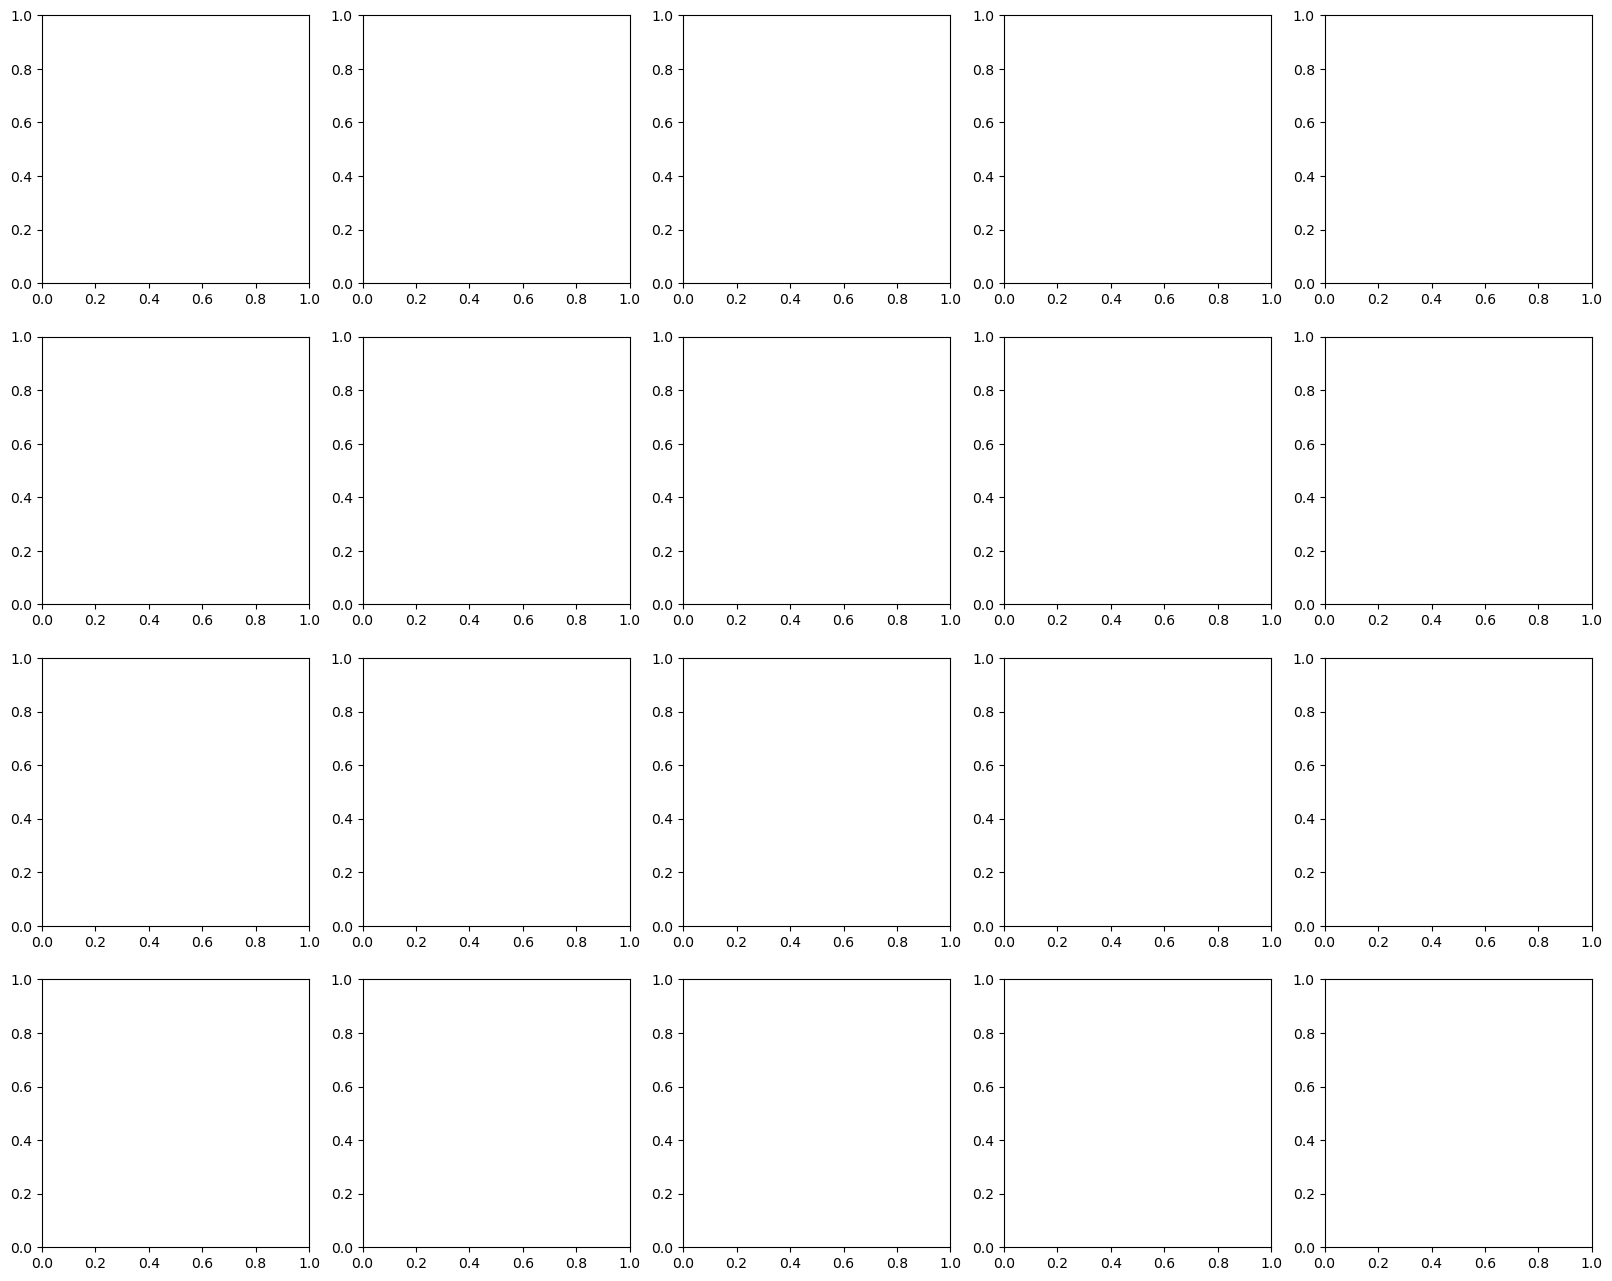

In [7]:
# define your sets of parameters
DELAY = 3

parameters_sets = [(i, DELAY, DATA_NAMES)  for i in [0,1,5,10]] # add more as needed (distance_tick, delay)

# decide on the layout of your subplots
n_rows = 4
n_cols = 5

# create a figure and a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,16))

# to keep track of where the next subplot should be
row = 0
col = 0

# iterate through your sets of parameters
for params in parameters_sets:
    levels_to_buckets_to_bid_probas, levels_to_buckets_to_ask_probas = get_exec_probas(*params)
    for level in range(5):
        x_ =levels_to_buckets_to_ask_probas[level].keys()
        sns.regplot(x=list(x_), y=list(levels_to_buckets_to_ask_probas[level].values()), color='red', ax=axs[row, col], scatter_kws={'s':10})
        sns.regplot(x=list(x_), y=list(levels_to_buckets_to_bid_probas[level].values()), color='green', ax=axs[row, col], scatter_kws={'s':10})
        
        # set the title of each subplot as the parameters tuple
        axs[row, col].set_title(f'dist_tick ={params[0]}, level={level}')
        
        
        #update row and col to point to the next subplot
        col += 1
        if col == n_cols:
            col = 0
            row += 1

# add a title for the whole figure
fig.suptitle(f'Execution Probabilities for different levels and tick distance, for a delay {DELAY}',y=1.02)

# improve layout
plt.tight_layout()
plt.show()